# 🚗📸📡 Гибридная система идентификации автомобилей: фотофиксация + RFID  
**Алгоритм сопоставления номера и RFID-метки для повышения точности распознавания**

В этом блокноте моделируется **гибридная система распознавания транспортных средств**, объединяющая:

- 📸 **Фотофиксацию** — для визуального распознавания номерного знака  
- 📡 **RFID-считывание** — для бесконтактной идентификации с помощью радиочастотной метки

🔁 При несовпадении или частичном распознавании номера, система **сопоставляет события** от камеры и RFID-считывателя, используя:

- ⏱️ временной интервал проезда  
- 📏 расстояния фиксации (камера ~100 м, RFID ~10 м)  
- 🚙 марку транспортного средства  
- 🔡 количество совпадающих символов номера

🎯 **Цель**: повысить надёжность идентификации автомобиля при сбоях в одной из подсистем (например, при плохом фото или сбое считывателя)

In [1]:
import copy
import numpy as np

from pysim.experiments.utility.hybrid_helper import *
from pysim.models.hybrid.objects import Params

## 🔍 Эксперимент №1: Влияние RFID на эффективность гибридной системы

**🎯 Цель эксперимента:**  
Оценить, как **вероятность успешной идентификации автомобиля RFID-системой** влияет на **общую вероятность распознавания автомобиля** гибридной системой, сочетающей радиочастотную- и фото- идентификацию.

**🧪 Условия:**
- **Ось X** — вероятность успешного считывания RFID-метки (от `0` до `1`);
- **Ось Y** — итоговая вероятность, что система правильно распознает автомобиль;
- Каждая линия на графике — отдельный сценарий с фиксированной вероятностью распознавания номера **камерой** (`0.0`, `0.25`, `0.5`, `0.75`, `1.0`);
- Вероятность распознавания **модели автомобиля** установлена на уровне `0.7`.

---

### 📊 Что видно на графике:

- 📈 **Все линии возрастают**: чем выше точность RFID-системы, тем выше общая вероятность идентификации;
- 🟣 **Даже при нулевой точности камеры** (фиолетовая линия) система всё равно даёт положительный результат при хорошем RFID;
- 🔵 **При максимальной точности камеры** (синяя линия) RFID почти не влияет — система и так даёт 100% результат;
- 📉 **Чем хуже работает камера**, тем **важнее становится RFID**: при идентификации камерой `0.25`, повышение RFID с `0` до `1` увеличивает общую точность более чем на `60%`.

---

### 📌 Выводы:

- ✅ RFID-идентификация **критически важна**, особенно когда камера работает нестабильно (дождь, снег, темнота);
- 💡 Гибридная система остаётся надёжной даже при отказе одного из компонентов — она компенсирует недостатки каждого источника данных.

### 🛠️ Подготовка входных данных | Эксперимент №1

In [2]:
params_dict = Params().model_dump()
# Изменяющийся параметр в рамках эксперимента
variadic = "rfid_error"
rfid_probs = np.linspace(
    Probs.MIN_ERROR_RFID_PROB, Probs.MAX_ERROR_RFID_PROB, Consts.NUM_POINTS
)
params_dict[variadic] = rfid_probs

# Для каждой кривой своё значение вероятности идентификации камерой
line_variable = "photo_error"
number_photo_err = np.linspace(Probs.MIN_ERROR_CAM_PROB, Probs.MAX_ERROR_CAM_PROB, Consts.NUM_LINES)
symbol_photo_err = [
    plate_to_symbol_error(p, params_dict["number_plate_symbols_amount"])
    for p in number_photo_err
]
params_list: list[dict[str, Any]] = []
for photo_err in symbol_photo_err:
    params_dict[line_variable] = photo_err
    params_list.append(copy.deepcopy(params_dict))

# Название интересующего параметра в результатах
result_param_name = "total_prob"


### 🧪 Получение результатов | Эксперимент №1

In [3]:
res_probs = get_experiments_results(
    variadic=variadic,
    variadic_values=rfid_probs,
    line_variable=line_variable,
    line_variable_values=number_photo_err,
    params_list=params_list,
    result_param_name=result_param_name,
    use_json=False,
    save_results=True,
    file_name="rfid_probs_0.5.json"
)
# Моделирование на M3 Pro для 20000 номеров:
# Моделирование по переменной rfid_error: 100%
#  5/5 [01:04<00:00, 16.73s/кривая]

Моделирование по переменной rfid_error:   0%|          | 0/5 [00:00<?, ?кривая/s]

### 📊 Визуализация результатов | Эксперимент №1

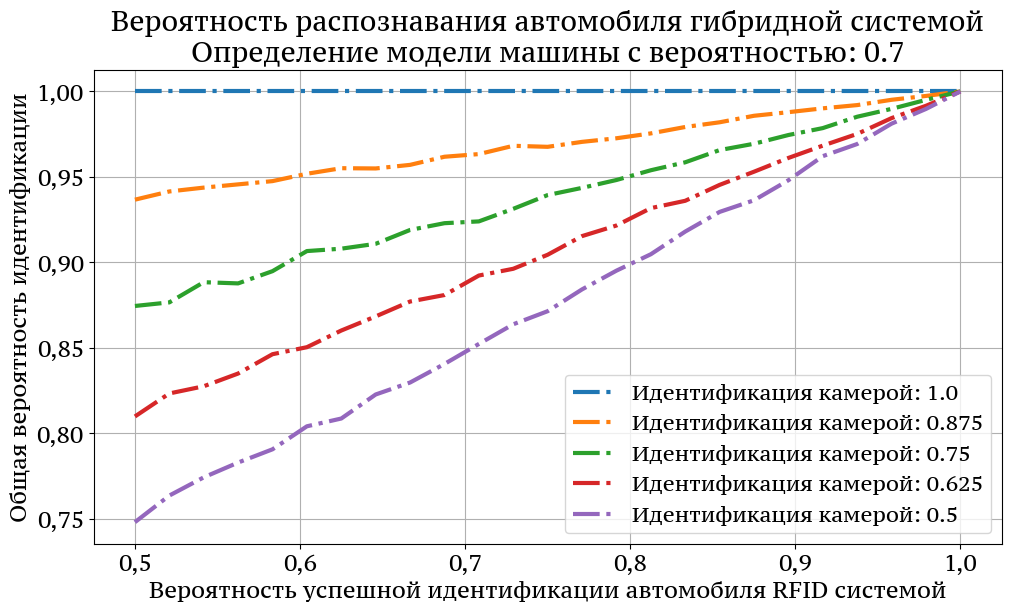

In [5]:
rfid_probs = np.linspace(0.5, 1, 25) # Из-за инверсии вероятности ошибки в вероятность успеха
plot_experiment_lines(
    x_values=rfid_probs,
    y_lines=res_probs,
    labels=[f"Идентификация камерой: {1 - number_photo_err[i]}" for i in range(Consts.NUM_LINES)],
    xlabel="Вероятность успешной идентификации автомобиля RFID системой",
    ylabel="Общая вероятность идентификации",
    title=f"Вероятность распознавания автомобиля гибридной системой\nОпределение модели машины с вероятностью: {1-params_dict['car_error']}",
    image_name="rfid_probs",
    save_fig=False
)

## 📸 Эксперимент №2: Влияние фотофиксации на эффективность гибридной системы

**🎯 Цель эксперимента:**  
Оценить, как **вероятность успешной идентификации номера камерой** влияет на **общую вероятность распознавания автомобиля** гибридной системой, объединяющей визуальное и радиочастотное считывание.

**🧪 Условия:**
- **Ось X** — вероятность успешной идентификации номера **камерой** (от `0` до `1`);
- **Ось Y** — итоговая вероятность, что гибридная система правильно распознает автомобиль;
- Каждая линия на графике — отдельный сценарий с фиксированной вероятностью идентификации **RFID системой** (`0.0`, `0.25`, `0.5`, `0.75`, `1.0`);
- Вероятность распознавания **модели автомобиля** установлена на уровне `0.7`.

---

### 📊 Что видно на графике:

- 📈 **Все линии возрастают**: чем выше вероятность правильной работы камеры, тем надёжнее работает вся система;
- 🔵 **При 100% точности RFID** (синяя линия) система почти всегда работает идеально, даже при слабой фотофиксации;
- 🟣 **При нулевой точности RFID** (фиолетовая линия) результат полностью зависит от камеры;
- 📉 **Чем хуже работает RFID**, тем **важнее роль камеры** — при RFID = 0.25, повышение точности камеры с `0` до `1` повышает общую точность почти на `80%`.

---

### 📌 Выводы:

- ✅ Фотофиксация играет **ключевую роль**, особенно при сбоях RFID-системы (экранирование, сбои метки);
- ⚖️ Гибридная система **адаптивна** — при ухудшении одного компонента (камера или RFID), другой может компенсировать падение точности.

### 🛠️ Подготовка входных данных | Эксперимент №2

In [6]:
params_dict = Params().model_dump()
# Изменяющийся параметр в рамках эксперимента
variadic = "photo_error"
photo_probs = np.linspace(
    Probs.MIN_ERROR_CAM_PROB, Probs.MAX_ERROR_CAM_PROB, Consts.NUM_POINTS
)
photo_err_probs_list = [
    plate_to_symbol_error(p, params_dict["number_plate_symbols_amount"])
    for p in photo_probs
]
params_dict[variadic] = photo_err_probs_list

# Для каждой кривой своё значение вероятности идентификации RFID системой
line_variable = "rfid_error"
rfid_err_probs_list = np.linspace(
    Probs.MIN_ERROR_RFID_PROB, Probs.MAX_ERROR_RFID_PROB, Consts.NUM_LINES
)
params_list: list[dict] = []
for rfid_err in rfid_err_probs_list:
    params_dict["rfid_error"] = rfid_err
    params_list.append(copy.deepcopy(params_dict))

# Название интересующего параметра в результатах
result_param_name = "total_prob"

### 🧪 Получение результатов | Эксперимент №2

In [7]:
res_probs = get_experiments_results(
    variadic=variadic,
    variadic_values=photo_probs,
    line_variable=line_variable,
    line_variable_values=rfid_err_probs_list,
    params_list=params_list,
    result_param_name=result_param_name,
    use_json=False,
    save_results=True,
    file_name="photo_probs_0.5.json"
)
# Моделирование на M3 Pro для 20000 номеров:
# Моделирование по переменной photo_error: 100%
#  5/5 [01:04<00:00,  9.78s/кривая]

Моделирование по переменной photo_error:   0%|          | 0/5 [00:00<?, ?кривая/s]

### 📊 Визуализация результатов | Эксперимент №2

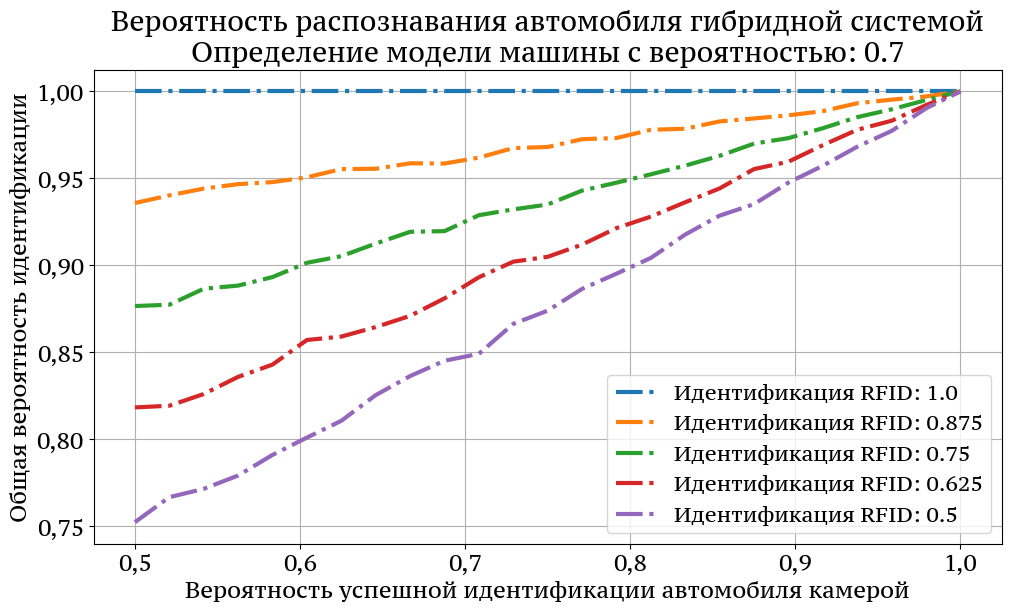

In [9]:
photo_probs = np.linspace(0.5, 1, 25) # Из-за инверсии вероятности ошибки в вероятность успеха
plot_experiment_lines(
    x_values=photo_probs,
    y_lines=res_probs,
    labels=[f"Идентификация RFID: {1 - rfid_err_probs_list[i]}" for i in range(Consts.NUM_LINES)],
    xlabel="Вероятность успешной идентификации автомобиля камерой",
    ylabel="Общая вероятность идентификации",
    title=f"Вероятность распознавания автомобиля гибридной системой\nОпределение модели машины с вероятностью: {1-params_dict['car_error']}",
    image_name="photo_probs",
    save_fig=False
)

## 🚘 Эксперимент №3: Влияние точности определения модели автомобиля на гибридную систему

**🎯 Цель эксперимента:**  
Изучить, как **вероятность успешной идентификации модели автомобиля** влияет на **общую эффективность гибридной системы**, при фиксированных уровнях фото- и RFID-идентификации.

**🧪 Условия:**
- **Ось X** — вероятность того, что модель автомобиля будет определена корректно (`0` → полностью случайное определение, `1` → безошибочное);
- **Ось Y** — итоговая вероятность, что гибридная система успешно распознает автомобиль;
- Каждая линия на графике — отдельный сценарий с фиксированной вероятностью идентификации **камерой** (`0.0`, `0.0625`, `0.125`, `0.1875`, `0.25`);
- **RFID работает безошибочно** — вероятность идентификации метки установлена в `1.0`.

---

### 📊 Что видно на графике:

- 📈 **Все линии возрастают с ростом точности определения модели**;
- 🔵 **При слабой работе камеры** (фиолетовая кривая) результат критически зависит от качества определения модели;
- 🔴 **При хорошей работе камеры** система демонстрирует высокую эффективность даже при неуверенном определении модели;
- ⚠️ **Модель автомобиля** выступает как **дополнительный критерий** для разрешения конфликтов — особенно это заметно, когда камера "молчит".

---

### 📌 Выводы:

- ✅ Качество определения модели машины не оказывает заметного влияния на итоговую точность гибридной системы;
- 💡 Результат заметен только при крайне низкой (порядка 1-2 %) вероятности идентификации камерой (например, в тумане или при сильном загрязнении номера);

### 🛠️ Подготовка входных данных | Эксперимент №3

In [8]:
params_dict = Params().model_dump()
# Изменяющийся параметр в рамках эксперимента
variadic = "car_error"
model_probs = np.linspace(
    Probs.MIN_ERROR_RFID_PROB, Probs.MAX_ERROR_RFID_PROB, Consts.NUM_POINTS
)
params_dict[variadic] = model_probs

# Для каждой кривой своё значение вероятности идентификации камерой
line_variable = "photo_error"
number_photo_err = np.linspace(
    0.75, Probs.MAX_ERROR_CAM_PROB, Consts.NUM_LINES
)
photo_err_probs_list = [
    plate_to_symbol_error(p, params_dict["number_plate_symbols_amount"])
    for p in number_photo_err
]
params_list: list[dict] = []
for photo_err in photo_err_probs_list:
    params_dict["photo_error"] = photo_err
    params_list.append(copy.deepcopy(params_dict))

# Название интересующего параметра в результатах
result_param_name = "total_prob"

### 🧪 Получение результатов | Эксперимент №3

In [9]:
res_probs = get_experiments_results(
    variadic=variadic,
    variadic_values=model_probs,
    line_variable=line_variable,
    line_variable_values=number_photo_err,
    params_list=params_list,
    result_param_name=result_param_name,
    use_json=True,
    save_results=False,
    file_name="model_probs.json"
)
# Моделирование на M3 Pro для 20000 номеров:
# Моделирование по переменной car_error: 100%
#  5/5 [01:46<00:00, 29.27s/кривая]

### 📊 Визуализация результатов | Эксперимент №3

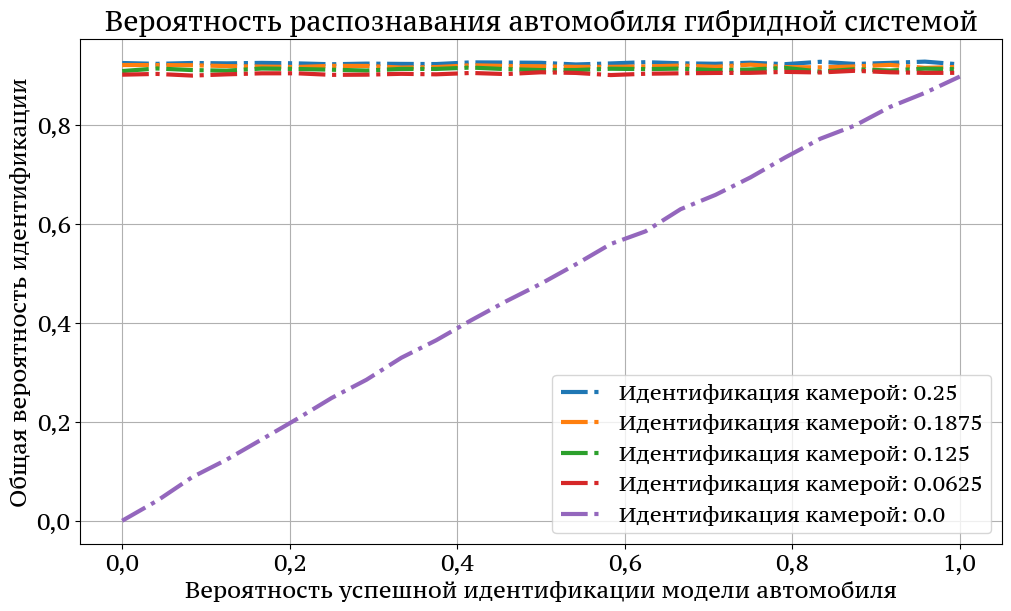

In [10]:
plot_experiment_lines(
    x_values=model_probs,
    y_lines=res_probs,
    labels=[f"Идентификация камерой: {1 - number_photo_err[i]}" for i in range(Consts.NUM_LINES)],
    xlabel="Вероятность успешной идентификации модели автомобиля",
    ylabel="Общая вероятность идентификации",
    title=f"Вероятность распознавания автомобиля гибридной системой",
    image_name="model_probs",
    save_fig=True
)

## 🚧 Эксперимент №4: Влияние точности фотофиксации на вероятность коллизий

**🎯 Цель эксперимента:**  
Оценить, как **вероятность успешной идентификации номера камерой** влияет на **частоту возникновения коллизий** — ситуаций, когда система не может однозначно сопоставить номер с автомобилем.

**🧪 Условия:**
- **Ось X** — вероятность, что камера успешно считает **весь номер** автомобиля (`0.0` → камера ничего не видит, `1.0` → идеальное считывание);
- **Ось Y** — доля номеров, попавших в коллизию (совпадение с другим автомобилем по данным);
- Все параметры системы зафиксированы, кроме **расстояния между автомобилями** — для каждой линии оно своё (`1.0`, `4.5`, `8.0`, `11.5`, `15.0` м);
- **RFID работает безошибочно** (ошибка равна `0.0`);
- Модель автомобиля используется с высокой точностью (вероятность `0.7`).

---

### 📊 Что показывает график:

- 🔻 **Чем ниже точность камеры**, тем выше вероятность коллизий;
- 🟣 При **нулевой точности фотофиксации** доля совпадений приближается к `1.0` — система "вслепую" принимает решения на основе модели и RFID, что приводит к массовым ошибкам;
- 📉 При увеличении вероятности корректного считывания номера доля коллизий **резко падает**, даже при малом расстоянии между машинами;
- 📏 Увеличение расстояния между автомобилями **немного снижает риск коллизий**, но ключевым фактором остаётся именно точность камеры.

---

### 📌 Выводы:

- 🚗 При плотном транспортном потоке (малая дистанция) особенно важно обеспечить хорошее качество визуального распознавания;
- 💡 Даже при нулевой RFID-ошибке, система может «провалиться», если камера не даёт полезной информации.

### 🛠️ Подготовка входных данных | Эксперимент №4

In [11]:
params_dict = Params().model_dump()
# Изменяющийся параметр в рамках эксперимента
variadic = "photo_error"
photo_probs = np.linspace(
    Probs.MIN_ERROR_CAM_PROB, Probs.MAX_ERROR_CAM_PROB, Consts.NUM_POINTS
)
photo_err_probs_list = [
    plate_to_symbol_error(p, params_dict["number_plate_symbols_amount"])
    for p in photo_probs
]
params_dict[variadic] = photo_err_probs_list

# Для корректности результатов RFID должен работать без ошибок
params_dict["rfid_error"] = 0

# Для каждой кривой своё значение вероятности определения модели машины
line_variable = "transport_gap"
gap_list = np.linspace(
    1, 15, Consts.NUM_LINES
)

params_list: list[dict] = []
for gap in gap_list:
    params_dict["transport_gap"] = gap
    params_list.append(copy.deepcopy(params_dict))

# Название интересующего параметра в результатах
result_param_name = "collision_amount_to_nums"

### 🧪 Получение результатов | Эксперимент №4

In [12]:
res_probs = get_experiments_results(
    variadic=variadic,
    variadic_values=photo_probs,
    line_variable=line_variable,
    line_variable_values=gap_list,
    params_list=params_list,
    result_param_name=result_param_name,
    use_json=True,
    save_results=False,
    file_name="collision_amount_to_nums.json"
)
# Моделирование на M3 Pro для 20000 номеров:
# Моделирование по переменной photo_error: 100%
#  5/5 [01:53<00:00, 22.42s/кривая]

### 📊 Визуализация результатов | Эксперимент №4

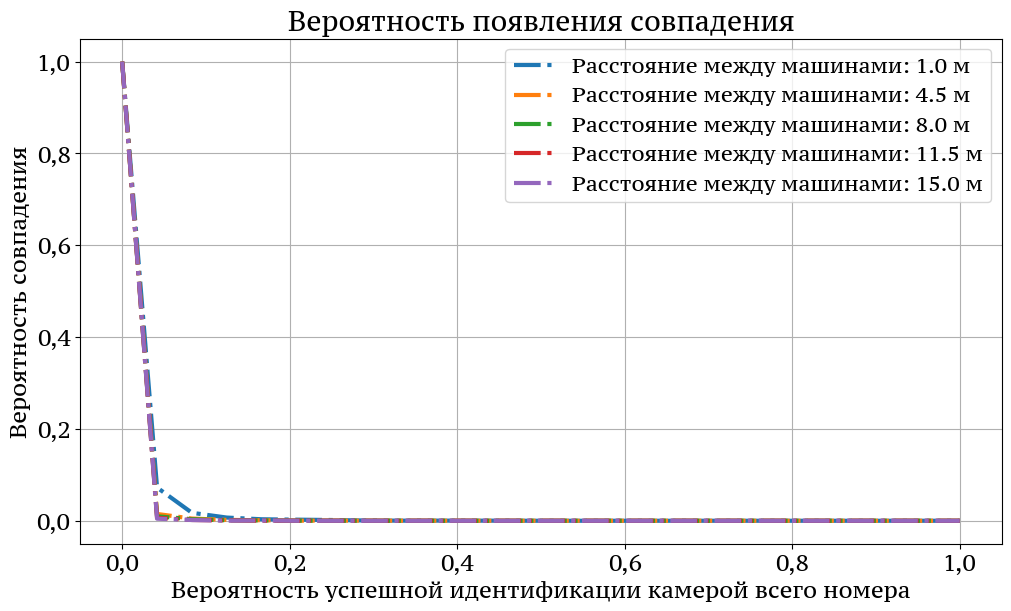

In [13]:
plot_experiment_lines(
    x_values=photo_probs,
    y_lines=res_probs,
    labels=[f"Расстояние между машинами: {gap_list[i]} м" for i in range(Consts.NUM_LINES)],
    xlabel="Вероятность успешной идентификации камерой всего номера",
    ylabel="Вероятность совпадения",
    title="Вероятность появления совпадения",
    image_name="collision_amount_to_nums",
    save_fig=False
)

## 🚫 Эксперимент №5: Неразрешённые коллизии при высоких ошибках камеры

**🎯 Цель эксперимента:**  
Изучить, как **вероятность ошибки камеры при распознавании номера** влияет на **долю неразрешённых совпадений (коллизий)**, при различных уровнях точности определения **модели автомобиля**.

**🧪 Условия:**
- **Ось X** — вероятность ошибки камеры при распознавании **всего номера целиком** (исследуется при значениях от `0.97` до `1.0`);
- **Ось Y** — вероятность появления **неразрешённого совпадения**, когда система не смогла отличить автомобили друг от друга;
- Каждая линия на графике соответствует своей вероятности успешного определения **модели автомобиля** (`0.0`, `0.25`, `0.5`, `0.75`, `1.0`);
- RFID-система работает **идеально** (ошибка = `0.0`);
- Все остальные параметры системы зафиксированы.

---

### 📊 Что показывает график:

- 📈 При **приближении ошибки камеры к 100%**, вероятность неразрешённых совпадений **резко возрастает**;
- 🔵 **Если модель автомобиля распознаётся точно** (синяя линия), даже высокая ошибка камеры **не приводит к неразрешимому совпадению**;
---

### 📌 Выводы:

- ⚠️ При высоких значениях ошибок камеры система **теряет устойчивость** — особенно если модель автомобиля тоже не определяется;
- ✅ Надёжное определение **модели ТС** может компенсировать даже плохую работу камеры;
- 🤝 **Согласованная работа всех модулей** (камера + определение модели + RFID) — ключ к устойчивой идентификации в реальных условиях (туман, загрязнение, погодные помехи).

### 🛠️ Подготовка входных данных | Эксперимент №5

In [14]:
params_dict = Params().model_dump()

# Изменяющийся параметр в рамках эксперимента
variadic = "photo_error"
photo_probs = np.linspace(0.97, Probs.MAX_ERROR_CAM_PROB, Consts.NUM_POINTS)
photo_err_probs_list = [
    plate_to_symbol_error(p, params_dict["number_plate_symbols_amount"])
    for p in photo_probs
]
params_dict[variadic] = photo_err_probs_list

# Для корректности результатов RFID должен работать без ошибок
params_dict["rfid_error"] = 0

# Для каждой кривой своё значение вероятности идентификации модели машины
line_variable = "car_error"
model_err_probs_list = np.linspace(
    Probs.MIN_ERROR_CAM_PROB, Probs.MAX_ERROR_CAM_PROB, Consts.NUM_LINES
)
params_list: list[dict] = []
for model_err in model_err_probs_list:
    params_dict["car_error"] = model_err
    params_list.append(copy.deepcopy(params_dict))

# Название интересующего параметра в результатах
result_param_name = "unresolved_collision_prob"

### 🧪 Получение результатов | Эксперимент №5

In [15]:
res_probs = get_experiments_results(
    variadic=variadic,
    variadic_values=photo_probs,
    line_variable=line_variable,
    line_variable_values=model_err_probs_list,
    params_list=params_list,
    result_param_name=result_param_name,
    use_json=True,
    save_results=False,
    file_name="unresolved_collision_prob.json"
)
# Моделирование на M3 Pro для 20000 номеров:


### 📊 Визуализация результатов | Эксперимент №5

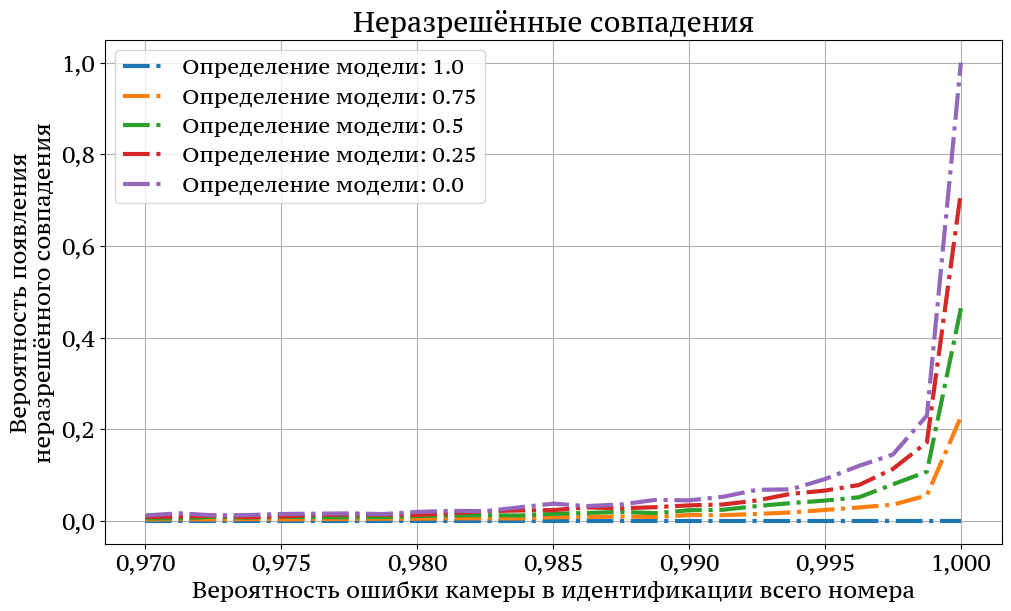

In [16]:
plot_experiment_lines(
    x_values=photo_probs,
    y_lines=res_probs,
    labels=[f"Определение модели: {1 - model_err_probs_list[i]}" for i in range(Consts.NUM_LINES)],
    xlabel="Вероятность ошибки камеры в идентификации всего номера",
    ylabel="Вероятность появления\nнеразрешённого совпадения",
    title="Неразрешённые совпадения",
    image_name="unresolved_collision_prob",
    save_fig=True,
    inversion=False
)

## ❌ Эксперимент №6: Неправильно разрешённые коллизии при ошибках камеры

**🎯 Цель эксперимента:**  
Проанализировать, как **ошибки камеры при распознавании номера** влияют на **число неправильно разрешённых коллизий**, при разных уровнях точности определения **модели автомобиля**.

**🧪 Условия:**
- **Ось X** — вероятность ошибки камеры при распознавании **всего номера целиком** (`0.97`–`1.0`);
- **Ось Y** — **количество неправильно разрешённых совпадений**, т.е. случаев, когда система **ошибочно сопоставила данные** от камеры и RFID;
- Каждая кривая — это фиксированное значение вероятности определения **модели автомобиля** (`0.0`, `0.25`, `0.5`, `0.75`, `1.0`);
- RFID-модуль работает **без ошибок** (идеально);
- Остальные параметры зафиксированы.

---

### 📊 Что показывает график:

- 🚨 При **практически полной неработоспособности камеры** (ошибка ~ `1.0`) начинают массово появляться **ошибочные сопоставления**;
- 🟣 **Если модель не распознаётся** (фиолетовая линия), система никак не може разрешать совпадения — количество ошибок остаётся нулевым;
- 🔁 **Парадокс**: объясняется тем, что чем лучше распознаётся модель, тем больше попыток разрешить совпадения → выше риск ошибочного сопоставления.

---

### 📌 Выводы:

- ⚠️ При высокой вероятности ошибок камеры **механизмы разрешения коллизий могут немного навредить**;
- 🧠 Алгоритм должен учитывать **уверенность в данных**, прежде чем применять логику сопоставления.

### 🧪 Получение результатов | Эксперимент №6

In [17]:
# Название интересующего параметра в результатах
result_param_name = "error_collision_resolve_amount"

res_probs = get_experiments_results(
    variadic=variadic,
    variadic_values=photo_probs,
    line_variable=line_variable,
    line_variable_values=model_err_probs_list,
    params_list=params_list,
    result_param_name=result_param_name,
    use_json=True,
    save_results=False,
    file_name="unresolved_collision_prob.json"
)

### 📊 Визуализация результатов | Эксперимент №6

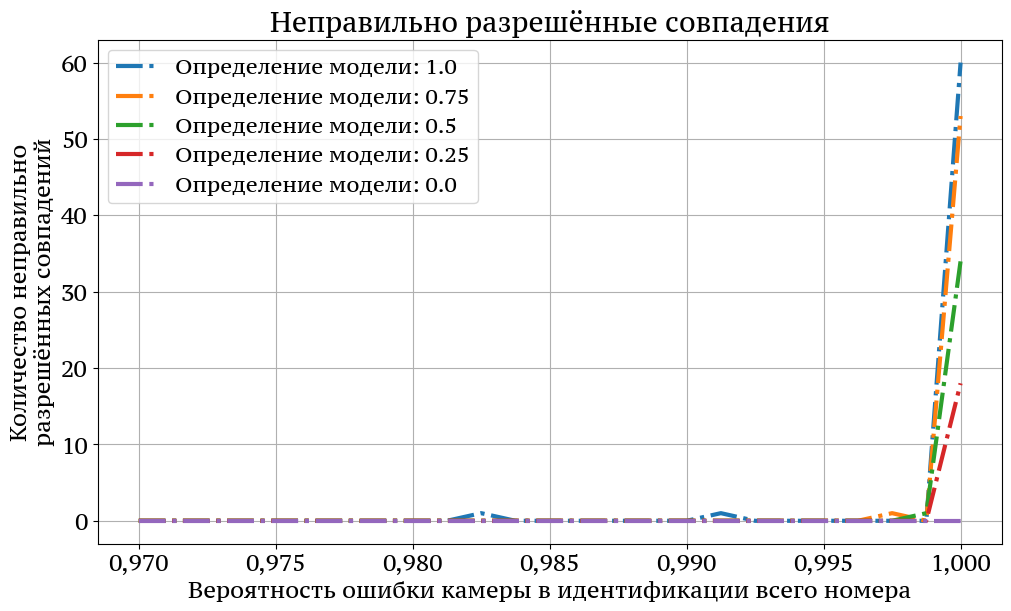

In [18]:
plot_experiment_lines(
    x_values=photo_probs,
    y_lines=res_probs,
    labels=[f"Определение модели: {1 - model_err_probs_list[i]}" for i in range(Consts.NUM_LINES)],
    xlabel="Вероятность ошибки камеры в идентификации всего номера",
    ylabel="Количество неправильно\nразрешённых совпадений",
    title="Неправильно разрешённые совпадения",
    image_name="error_collision_resolve",
    save_fig=False,
    inversion=False
)